In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-area-segmentation/metadata.csv
/kaggle/input/flood-area-segmentation/Mask/1017.png
/kaggle/input/flood-area-segmentation/Mask/2015.png
/kaggle/input/flood-area-segmentation/Mask/1084.png
/kaggle/input/flood-area-segmentation/Mask/2021.png
/kaggle/input/flood-area-segmentation/Mask/1012.png
/kaggle/input/flood-area-segmentation/Mask/48.png
/kaggle/input/flood-area-segmentation/Mask/3012.png
/kaggle/input/flood-area-segmentation/Mask/1037.png
/kaggle/input/flood-area-segmentation/Mask/2009.png
/kaggle/input/flood-area-segmentation/Mask/1023.png
/kaggle/input/flood-area-segmentation/Mask/3070.png
/kaggle/input/flood-area-segmentation/Mask/37.png
/kaggle/input/flood-area-segmentation/Mask/1048.png
/kaggle/input/flood-area-segmentation/Mask/3068.png
/kaggle/input/flood-area-segmentation/Mask/1000.png
/kaggle/input/flood-area-segmentation/Mask/35.png
/kaggle/input/flood-area-segmentation/Mask/2030.png
/kaggle/input/flood-area-segmentation/Mask/1081.png
/kaggle/input/flood

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [3]:
import os

IMAGE_SIZE = 256
IMAGE_DIR = "/kaggle/input/flood-area-segmentation/Image"
MASK_DIR = "/kaggle/input/flood-area-segmentation/Mask"

def load_images(image_dir, mask_dir):
    images = []
    masks = []
    
    # Get the file names without extensions for comparison
    image_names = [os.path.splitext(f)[0] for f in os.listdir(image_dir)]
    mask_names = [os.path.splitext(f)[0] for f in os.listdir(mask_dir)]
    
    # Use only those files that have both image and mask
    common_files = set(image_names).intersection(mask_names)
    
    for file_name in common_files:
        image_path = os.path.join(image_dir, file_name + ".jpg")  # Change extension if needed
        mask_path = os.path.join(mask_dir, file_name + ".png")    # Change extension if needed
        
        print(f"Loading image: {image_path}")
        print(f"Loading mask: {mask_path}")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Check if image or mask failed to load
        if image is None:
            print(f"Failed to load image: {image_path}")
            continue
        if mask is None:
            print(f"Failed to load mask: {mask_path}")
            continue
        
        # Resize to a consistent size
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
        
        # Normalize images to [0, 1]
        image = image / 255.0
        mask = mask / 255.0
        
        images.append(image)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

# Load images and masks
images, masks = load_images(IMAGE_DIR, MASK_DIR)

# Debugging prints to ensure data is loaded
print(f"Loaded {len(images)} images.")
print(f"Loaded {len(masks)} masks.")

# Proceed with train-test split if data is successfully loaded
if len(images) == 0 or len(masks) == 0:
    print("No images or masks were loaded, please check the paths or dataset.")
else:
    X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)


Loading image: /kaggle/input/flood-area-segmentation/Image/21.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/21.png
Loading image: /kaggle/input/flood-area-segmentation/Image/1079.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/1079.png
Loading image: /kaggle/input/flood-area-segmentation/Image/3006.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/3006.png
Loading image: /kaggle/input/flood-area-segmentation/Image/3031.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/3031.png
Loading image: /kaggle/input/flood-area-segmentation/Image/2037.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/2037.png
Loading image: /kaggle/input/flood-area-segmentation/Image/3007.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/3007.png
Loading image: /kaggle/input/flood-area-segmentation/Image/1000.jpg
Loading mask: /kaggle/input/flood-area-segmentation/Mask/1000.png
Loading image: /kaggle/input/flood-area-segmentation/Image/1031.jp

In [4]:
print(os.listdir(IMAGE_DIR))
print(os.listdir(MASK_DIR))


['2008.jpg', '1075.jpg', '2029.jpg', '1031.jpg', '2021.jpg', '1024.jpg', '3014.jpg', '45.jpg', '20.jpg', '1009.jpg', '2028.jpg', '6.jpg', '2041.jpg', '2003.jpg', '1055.jpg', '1026.jpg', '3064.jpg', '1010.jpg', '1025.jpg', '3085.jpg', '1058.jpg', '3010.jpg', '5.jpg', '3011.jpg', '8.jpg', '2011.jpg', '3037.jpg', '1032.jpg', '3058.jpg', '2020.jpg', '3030.jpg', '1037.jpg', '3016.jpg', '3017.jpg', '30.jpg', '1002.jpg', '38.jpg', '2033.jpg', '1041.jpg', '42.jpg', '1071.jpg', '1019.jpg', '33.jpg', '10.jpg', '0.jpg', '2035.jpg', '1076.jpg', '35.jpg', '1018.jpg', '3066.jpg', '2051.jpg', '1078.jpg', '3077.jpg', '1067.jpg', '2016.jpg', '3040.jpg', '3025.jpg', '1080.jpg', '41.jpg', '2019.jpg', '3084.jpg', '1012.jpg', '1034.jpg', '1048.jpg', '3047.jpg', '1084.jpg', '3012.jpg', '3054.jpg', '1044.jpg', '3006.jpg', '1082.jpg', '3082.jpg', '2036.jpg', '1054.jpg', '1017.jpg', '9.jpg', '3028.jpg', '37.jpg', '2023.jpg', '1.jpg', '2046.jpg', '3005.jpg', '1060.jpg', '2010.jpg', '3086.jpg', '1053.jpg', '2002

In [5]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Downsampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Upsampling
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [6]:
model = unet_model()
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=16)


Epoch 1/25


I0000 00:00:1726927069.406939     128 service.cc:145] XLA service 0x7b0970024330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726927069.407054     128 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726927107.916718     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5127 - loss: 1.2111 - val_accuracy: 0.5673 - val_loss: 0.6803
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.6610 - loss: 0.6335 - val_accuracy: 0.7428 - val_loss: 0.5196
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.7638 - loss: 0.4997 - val_accuracy: 0.7522 - val_loss: 0.4955
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.7681 - loss: 0.4807 - val_accuracy: 0.7043 - val_loss: 0.5627
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.7561 - loss: 0.4971 - val_accuracy: 0.7712 - val_loss: 0.4632
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.7808 - loss: 0.4609 - val_accuracy: 0.7681 - val_loss: 0.4685
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 360ms/step - accuracy: 0.8082 - loss: 0.4245 - val_accuracy: 0.7618 - val_loss: 0.4802
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.7931 - loss: 0.4279 - val_accuracy: 0.7787 - val_lo

2/2 ━━━━━━━━━━━━━━━━━━━━ 49s 21s/step - accuracy: 0.8252 - loss: 0.3961
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


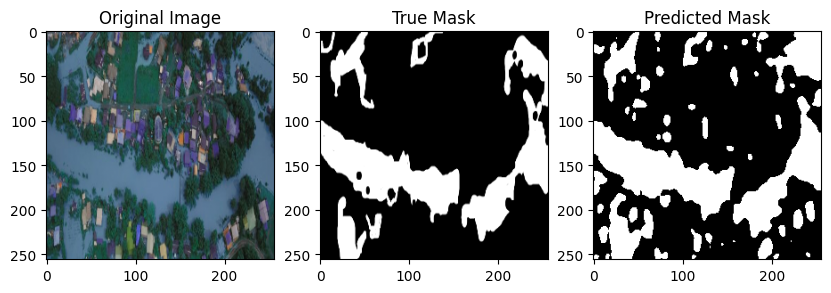

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


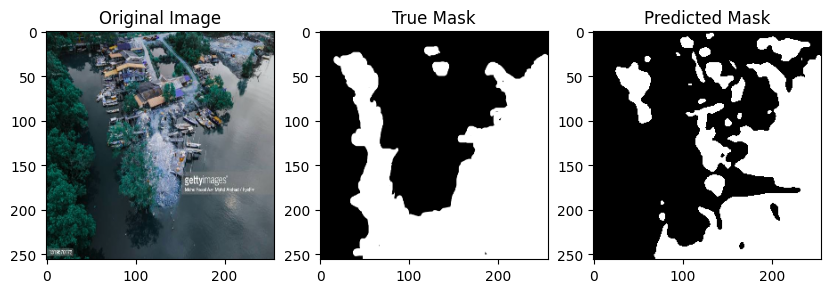

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


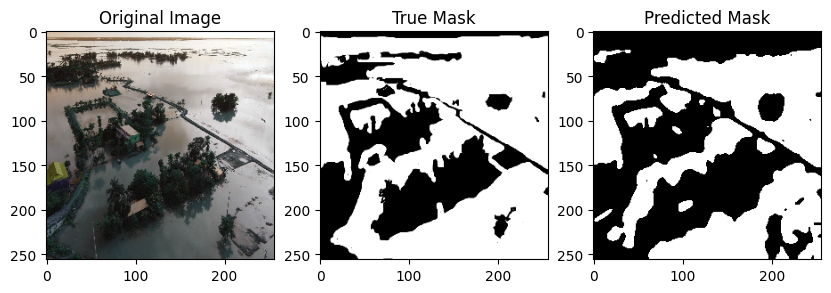

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


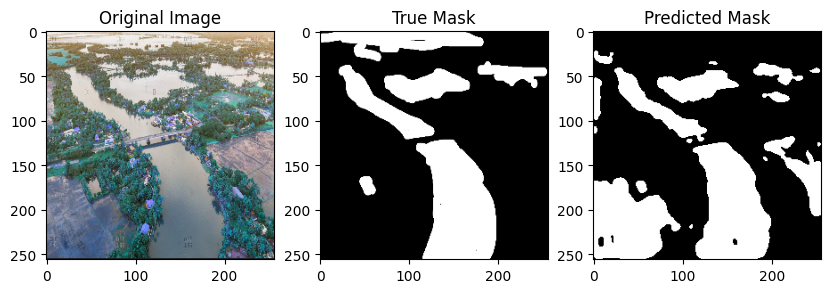

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


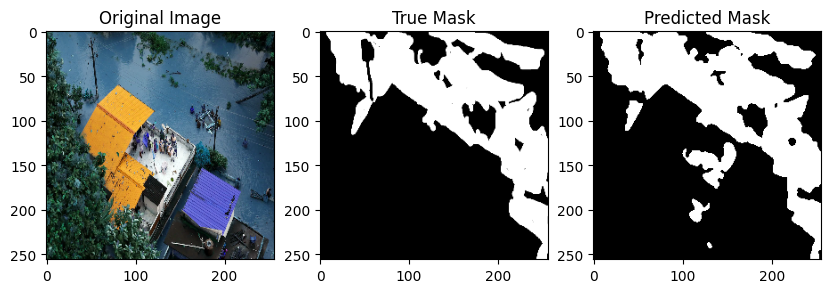

In [7]:
# Evaluate the model
model.evaluate(X_test, y_test)

# Visualize some predictions
def display_predictions(model, X_test, y_test, index):
    predicted_mask = model.predict(np.expand_dims(X_test[index], axis=0))
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(X_test[index])

    plt.subplot(1, 3, 2)
    plt.title("True Mask")
    plt.imshow(y_test[index], cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask[0], cmap='gray')

    plt.show()

# Display predictions for the first 5 test images
for i in range(5):
    display_predictions(model, X_test, y_test, i)


In [8]:
model.save('flood_segmentation_model.h5')
